In [1]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np
import xarray as xr
import netCDF4 as nc
import math

di = '/home/claire/Github-forked/MOM6-examples/ocean_only/seamount/isomip_float'

NHALO = 4
IC_FILE = 'MOM_IC.nc'
SHELF_IC_FILE = 'MOM_Shelf_IC.nc'
PROG_FILE = 'prog.nc'
ICE_SHELF_FILE = '/INPUT/shelfX.nc'
TOPO_FILE = '/INPUT/topogX.nc'
THICKNESS_FILE = '/INPUT/thickness.nc'

In [2]:
### new thickness file for THICKNESS_CONFIG="thickness_file"
### (depends on MOM6 output in IC_FILE, ie. use after a run)
def make_thickness_file(filename):
    
    ic = xr.open_dataset(di + '/' + IC_FILE)
    _, nz, ny, nx = ic.h.data.shape

    new_thick = nc.Dataset(filename, "w", format="NETCDF4")
    new_thick.createDimension("nz", nz)
    new_thick.createDimension("ny", ny)
    new_thick.createDimension("nx", nx)
    new_thick.createVariable("h","f8",("nz","ny","nx"))

    new_thick["h"][:,:,:] = ic.h.data
    new_thick.close()

In [3]:
### Make symmetric version of '/INPUT/Ocean1_3D.nc'
### symmetrized version to be stored in 'filename'
def symmetrize_ocean1(filename):
    
    isf = xr.open_dataset(di + "/INPUT/Ocean1_3D.nc")
    l_thick = isf.thick[:20,:]
    r_thick = np.flip(l_thick, axis=0)
    l_area = isf.area[:20,:]
    r_area = np.flip(l_area, axis=0)

    new_shelf = nc.Dataset(filename, "w", format="NETCDF4")
    new_shelf.createDimension("ny", 40)
    new_shelf.createDimension("nx", 240)
    new_shelf.createVariable("thick","f8",("ny","nx"))
    new_shelf.createVariable("area","f8",("ny","nx"))

    new_shelf["area"][:20,:] = l_area.data
    new_shelf["thick"][:20,:] = l_thick.data
    new_shelf["area"][20:,:] = r_area.data
    new_shelf["thick"][20:,:] = r_thick.data

    new_shelf.close()    

In [5]:
### New shelf: Make ISOMIP ice shelf half as massive
### in_filename must be different to out_filename
def make_shelf_half_as_massive(in_filename, out_filename):
    
    old_shelf = nc.Dataset(in_filename, "r") #! use ISOMIP ice shelf as model
    print(old_shelf)

    thi = old_shelf.variables["thick"][:,:]
    ar = old_shelf.variables["area"][:,:]

    new_shelf = nc.Dataset(out_filename, "w", format="NETCDF4")
    new_shelf.createDimension("ny", 40)
    new_shelf.createDimension("nx", 240)
    new_shelf.createVariable("thick","f8",("ny","nx"))

    new_shelf.createVariable("area","f8",("ny","nx"))

    new_shelf["area"][:,:] = ar
    new_shelf["thick"][:,:] = thi/2

    new_shelf.close()

In [4]:
### 3D depiction of topography and ice shelf
### (depends on MOM6 output in IC_FILE and SHELF_IC_FILE, ie. use after a run)
def display_config():
    
    ic = xr.open_dataset(di + "/"+ IC_FILE)
    ms = xr.open_dataset(di + "/" + SHELF_IC_FILE)
    #ms = xr.open_dataset(di + "/" + ICE_SHELF_FILE)
    #tp = xr.open_dataset(di + "/" + TOPO_FILE)

    LY, LX = ic.h.data[0].shape[1], ic.h.data[0].shape[2]
    YY= np.arange(0, LY, 1)
    XX = np.arange(0, LX, 1)
    XX, YY = np.meshgrid(XX, YY)

    fig, axes = plt.subplots(nrows = 1, ncols=2, figsize = (10,4), subplot_kw={"projection": "3d"})

    surf = axes[0].plot_surface(XX, YY, ms.h_shelf.data[0])
    #surf = axes[0].plot_surface(XX, YY, ms.thick.data)
    axes[0].set_title("Input ICE SHELF h")

    eta = ic.eta[0].data[0]
    bathyT = eta - np.sum(ic.h[0].data, axis=0)

    axes[1].plot_surface(XX, YY, eta)
    axes[1].plot_surface(XX, YY, bathyT)
    #topo2 = axes[1].plot_surface(XX, YY, -tp.depth.data)

    axes[1].set_title("Initial TOPOGRAPHY and ICE SHELF")

    ms.close()
    ic.close()

In [6]:
symmetrize_ocean1(di + "/INPUT/Ocean1_3D_symm.nc")
make_shelf_half_as_massive(di + "/INPUT/Ocean1_3D_symm.nc", di + ICE_SHELF_FILE)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): ny(40), nx(240)
    variables(dimensions): float64 thick(ny, nx), float64 area(ny, nx)
    groups: 


In [7]:
make_thickness_file(di + THICKNESS_FILE)

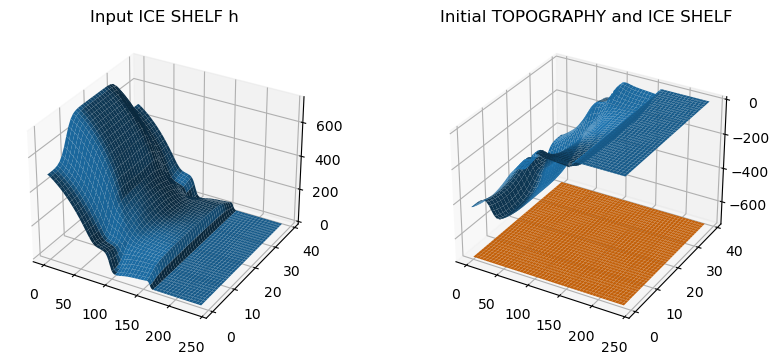

In [8]:
display_config()

### Plot output h,e,salt etc at chosen time

Text(0.5, 0.98, 'Run ends at 0001-01-06 00:00:00')

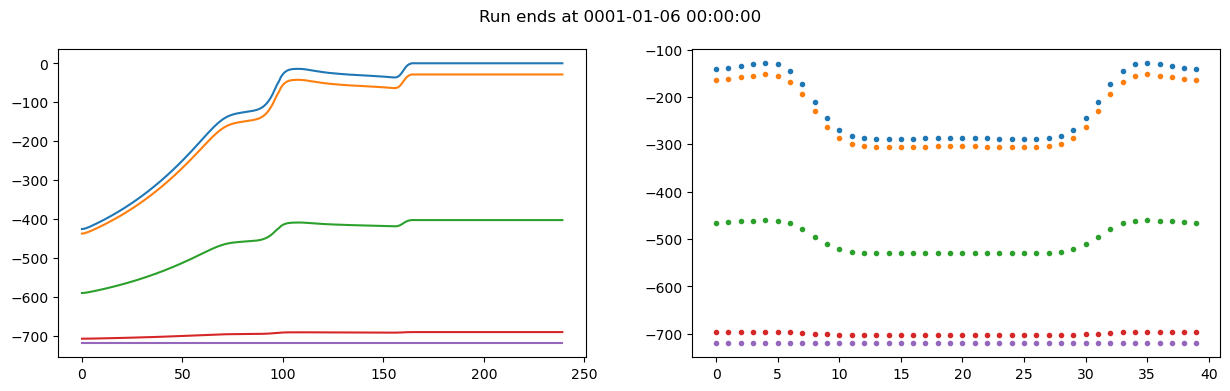

In [17]:
prog = xr.open_dataset(di + '/'+PROG_FILE)
last_time = prog.coords["Time"].values[-1]
     
fig,axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15,4))
tt=-1; zz= 14; yy=0; xx=71; ll = [0,1,zz,-2,-1] # ll=[0,1,2,3,4,5,10,-3,-2,-1]
for zzz in ll:
    axes[0].plot(prog.e[tt][zzz].data[yy,:])
    axes[1].plot(prog.e[tt][zzz].data[:,xx],'.')
fig.suptitle("Run ends at {}".format(last_time))

### Can see that the initial salt is "bad" with THICKNESS_CONFIG="ISOMIP" but "fixed" with THICKNESS_CONFIG="thickness_file" hack
ttt = -1; zzz = 0
plt.plot(prog.salt.data[ttt][zzz][yy,:])

In [10]:
np.nanmin(prog.h[0].data)

3.217029473201078

In [11]:
print(np.nanmax(prog.u.data[-1]), np.nanmin(prog.u.data[-1])) # 0.0012509557073082142 -0.0006301157530793094

0.0015186792977913612 -0.001289831916571113


In [12]:
print(np.nanmax(prog.v.data[-1]), np.nanmin(prog.v.data[-1])) # 0.0012509557073082142 -0.0006301157530793094

0.001008180549268265 -0.001008180549268265


In [13]:
arr = prog.u.data[-1]
ind = np.unravel_index(np.nanargmax(arr),arr.shape)
print(arr[ind])
ind

0.0015186792977913612


(14, 0, 71)

np.nanmin(prog.e.data[0])

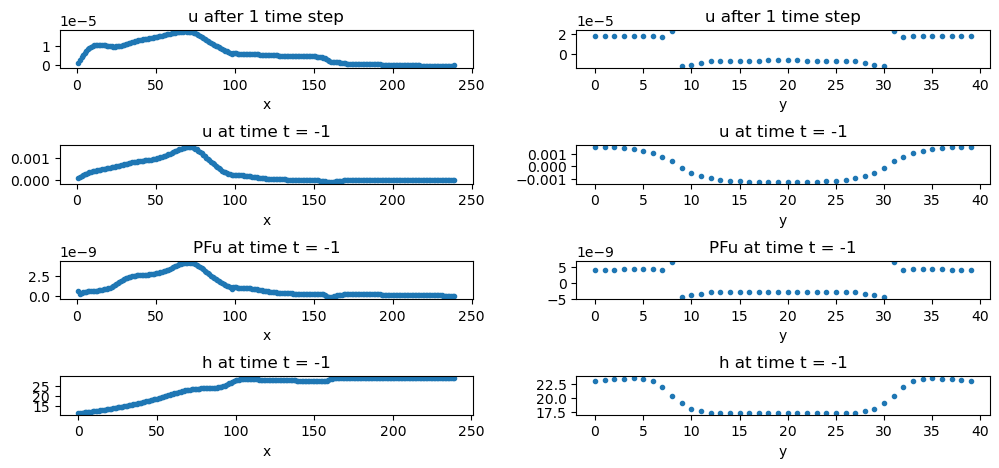

In [16]:
mo = xr.open_dataset(di + '/mom.nc')
fig,axes = plt.subplots(nrows = 4, ncols = 2, figsize = (12,5))

tt=-1; zz=14; yy=0; xx=71
showU = True
if (showU):
    u_or_v = "u"; PFu_or_v = "PFu"; prog_field = prog.u; mo_field = mo.PFu
else:
    u_or_v = "v"; PFu_or_v = "PFv"; prog_field = prog.v; mo_field = mo.PFv
    
axes[0,0].plot(prog_field[0][zz].data[yy,:],'.')
axes[0,0].set_xlabel("x")
axes[0,0].set_title("{} after 1 time step".format(u_or_v)) # depends on diag_table setting
axes[0,1].plot(prog_field[0][zz].data[:,xx],'.')
axes[0,1].set_xlabel("y")
axes[0,1].set_title("{} after 1 time step".format(u_or_v)) # depends on diag_table setting
axes[1,0].plot(prog_field[tt][zz].data[yy,:],'.',)
axes[1,0].set_xlabel("x")
axes[1,0].set_title("{} at time t = {}".format(u_or_v, tt))
axes[1,1].plot(prog_field[tt][zz].data[:,xx],'.')
axes[1,1].set_xlabel("y")
axes[1,1].set_title("{} at time t = {}".format(u_or_v,tt))
axes[2,0].plot(mo_field[tt][zz].data[yy,:],'.')
axes[2,0].set_xlabel("x")
axes[2,0].set_title("{} at time t = {}".format(PFu_or_v,tt))
axes[2,1].plot(mo_field[tt][zz].data[:,xx],'.',)
axes[2,1].set_xlabel("y")
axes[2,1].set_title("{} at time t = {}".format(PFu_or_v, tt))
axes[3,0].plot(prog.h[tt][zz].data[yy,:],'.')
axes[3,0].set_xlabel("x")
axes[3,0].set_title("h at time t = {}".format(tt))
axes[3,1].plot(prog.h[tt][zz].data[:,xx],'.',)
axes[3,1].set_xlabel("y")
axes[3,1].set_title("h at time t = {}".format(tt))

plt.subplots_adjust(wspace = 0.25, hspace = 2.0)

mo.close()

Text(0.5, 1.0, 'forcing at time t = -1')

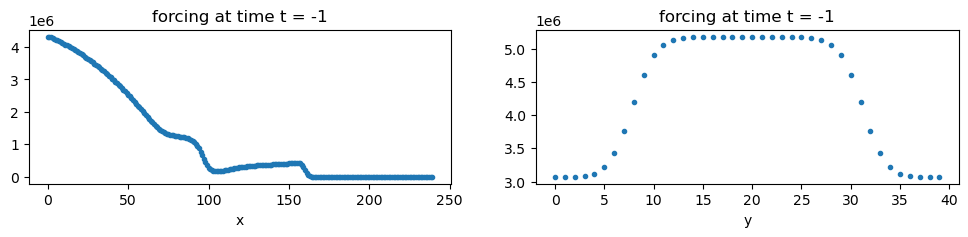

In [15]:
fc = xr.open_dataset(di + '/forcing.nc')

fig,axes = plt.subplots(nrows = 1, ncols = 2, figsize = (12,2))

tt=-1; yy=1; xx=39

#fc_field = fc.taux
#fc_field = fc.tauy
#fc_field = fc.ustar
#fc_field = fc.PRCmE
fc_field = fc.p_surf

#axes[0,0].plot(aft.u.data[zzz,yy+NHALO,NHALO:-NHALO])
axes[0].plot(fc_field[tt].data[yy,:],'.')
axes[0].set_xlabel("x")
axes[0].set_title("forcing at time t = {}".format(tt)) # depends on diag_table setting
axes[1].plot(fc_field[tt].data[:,xx],'.')
axes[1].set_xlabel("y")
axes[1].set_title("forcing at time t = {}".format(tt)) # depends on diag_table setting

### Make an "adjusted salt" file

#! Open files saved by MOM6 needed to adjust the salt 
bt=xr.open_dataset(di + "/deb_bathyT.nc") # topography file needed to calculate e
h=xr.open_dataset(di + '/after_ts_2_h.nc') # h file before the first time step, but after MOM6 remap
S=xr.open_dataset(di + '/before_finish_MOM_initialization_S.nc') # salt file produced by MOM6, which we want to adjust 

#! calculate e and then s as a linear function of e 
S_TOP = 33.8
S_BOTTOM = 34.55
MAXIMUM_DEPTH = 720.0
e=h.h.sum(axis=0).data-bt.bathyT.data
s=(e-h.h.data.cumsum(axis=0) + h.h.data/2)*(S_BOTTOM-S_TOP)/(-MAXIMUM_DEPTH) + S_TOP

#! fix the halo points
s[:,:NHALO,:NHALO]=0
s[:,:NHALO,-NHALO:]=0
s[:,-NHALO:,:NHALO]=0
s[:,-NHALO:,-NHALO:]=0

#! create new netcdf4 file for the adjusted salt based on the original salt file
nz, ny, nx = S.S.data.shape
new_salt = nc.Dataset(di + "/INPUT/adjustedS.nc", "w", format="NETCDF4")
new_salt.createDimension("nz", nz)
new_salt.createDimension("ny", ny)
new_salt.createDimension("nx", nx)
temp = new_salt.createVariable("S","f8",("nz","ny","nx"))
temp[:,:,:]=s
new_salt.close()

### Make new  topography and ice shelf files, if necessary

### New shelf: Cut the ISOMIP ice shelf in half

old_shelf = nc.Dataset(di + "/INPUT/Ocean1_3D.nc", "r") #! use ISOMIP ice shelf as model
print(old_shelf)

thi = old_shelf.variables["thick"][:,:]
 
ar = old_shelf.variables["area"][:,:]

print(thi[:,120:].shape)

new_shelf = nc.Dataset(di + "/INPUT/shelfX.nc", "w", format="NETCDF4")
new_shelf.createDimension("ny", 40)
new_shelf.createDimension("nx", 120)
new_shelf.createVariable("thick","f8",("ny","nx"))

new_shelf.createVariable("area","f8",("ny","nx"))

new_shelf["area"][:,:] = ar[:,120:]
new_shelf["thick"][:,:] = thi[:,120:]

new_shelf.close()

### New topography for half ISOMIP
#! use ISOMIP ice shelf as model
old_topo = nc.Dataset(di + "/deb_bathyT.nc", "r")
print(old_topo)

ba = old_topo.variables["bathyT"][:,:]

ba[4:-4,4+120:-4].shape
new_topog = nc.Dataset(di + "/INPUT/topogX.nc", "w", format="NETCDF4")
new_topog.createDimension("ny", 40)
new_topog.createDimension("nx", 120)
new_topog.createVariable("depth","f8",("ny","nx"))

new_topog["depth"][:,:] = ba[4:-4,4+120:-4]
    
new_topog.close()